# Modularizace základních operací

Úkolem cvičení je implementovat základní operace jako lineární funkce a sigmoid používané v neurosítích jako funkční bloky tak, aby je bylo možné skládat za sebe v libovolném pořadí. Návrh přebírá a kopíruje od knihovny PyTorch.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
import sys
sys.path.append('..')  # import tests

import torch

import ans
from tests import test_neural_library
from tests import randn_var

In [3]:
torch.set_printoptions(profile='short')

# Fukcionální rozhraní: modul `ans.functional` a třída `Function`

Ve cvičení [backpropagation.ipynb](backpropagation.ipynb) byly operace nad `Variable` definovány přepisem tzv. magických metod pro odpovídající operátory této třídy. Tento způsob je vhodný pro základní operace jako sčítání a násobení. Pro složitější operace jako konvoluce či rekurence však v Pythonu operátory, které bychom mohli definovat, neexistují. Navíc mohou mít tyto operace nepovinné parametry, které by nebylo jednoduché předat.

Operace s proměnnými `Variable` ale můžeme provádět i jako volání funkcí. Např. násobení dvou proměnných `u` a `v` by namísto `w = u * v` mohlo vypadat jako `w = multiply(u, v)`. Jednou z výhod takového návrhu je rozšiřitelnost i pro složitější operace s dodatečnými parametry. Funkce `multiply` by mohla vypadat takto:

In [4]:
def multiply(a: ans.autograd.Variable, b: ans.autograd.Variable) -> ans.autograd.Variable:
    def grad_fn(dout: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return dout * b.data, dout * a.data  
    return ans.autograd.Variable(
        a.data * b.data,
        parents=(a, b),
        grad_fn=grad_fn
    )

In [5]:
u = ans.autograd.Variable(2.)
v = ans.autograd.Variable(3.)
w = multiply(u, v)
w

Variable(6.0, grad_fn=multiply.<locals>.grad_fn)

In [6]:
w.grad_fn(torch.tensor(1.))  # du, dv

(tensor(3.), tensor(2.))

Analogicky bychom mohli definovat i sčítání.

In [7]:
def add(a: ans.autograd.Variable, b: ans.autograd.Variable) -> ans.autograd.Variable:
    def grad_fn(dout: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        return dout.clone(), dout.clone()
    return ans.autograd.Variable(
        a.data + b.data,
        parents=(a, b),
        grad_fn=grad_fn
    )

In [8]:
u = ans.autograd.Variable(2.)
v = ans.autograd.Variable(3.)
w = add(u, v)
w

Variable(5.0, grad_fn=add.<locals>.grad_fn)

In [9]:
w.grad_fn(torch.tensor(2.))  # du, dv

(tensor(2.), tensor(2.))

Tzv. boilerplate kód, kdy se musíme neustále starat o "vytahování" atributu `data: torch.Tensor` z `Variable` a vytváření `Variable` z výstupu se správně nastavenými `parents` atp., lze zautomatizovat. Abychom toho dosáhli, nejprve každou operaci nad objekty `Variable` jako `add` či `multiply` principiálně rozdělíme na dopředný a zpětný průchod, tj. např. jako `multiply_forward` a `multiply_backward`, přičemž oba budou pracovat se vstupy typu `torch.Tensor`.

In [10]:
def multiply_forward(a: torch.Tensor, b: torch.Tensor) -> tuple[torch.Tensor, tuple]:
    output = a * b
    cache = a, b
    return output, cache

In [11]:
def multiply_backward(doutput: torch.Tensor, cache=()) -> tuple[torch.Tensor, ...]:
    a, b = cache
    return doutput * b, doutput * a

Poté bude existovat třetí metoda `apply`, která bude zajišťovat jejich správné volání s proměnnými `Variable`.

In [12]:
def multiply_apply(*inputs: ans.autograd.Variable, **params) -> ans.autograd.Variable:
    tensor_args = [i.data for i in inputs]
    output_data, cache = multiply_forward(*tensor_args, **params)
    return ans.autograd.Variable(
        output_data,
        parents=inputs,
        grad_fn=functools.partial(multiply_backward, cache=cache)
    )

In [13]:
u = ans.autograd.Variable(2.)
v = ans.autograd.Variable(3.)
w = multiply_apply(u, v)
w

Variable(6.0, grad_fn=multiply_backward)

In [14]:
w.parents[0] is u, w.parents[1] is v

(True, True)

In [15]:
w.grad_fn(torch.tensor(1.))  # du, dv

(tensor(3.), tensor(2.))

Zatím jsme si příliš nepomohli, protože namísto jedné teď máme metody tři a ještě specializované výhradně na operaci násobení. Postup ovšem zobecníme a zabalíme do obecné šablony v podobě základní třídy `Function` v modulu `ans.functional`. Všechny operace, které budeme definovat, budou odvozeny (dědit z) z této třídy, což mimo jiné znamená, že `apply` bude existovat pouze jedna.

Základní třída `Function` má tři metody:

``` python
@staticmethod
def forward(*inputs: torch.Tensor, **params: Any) -> tuple[torch.Tensor, tuple]
```
Funkce deklaruje obecnou podobu dopředného průchodu jakékoliv diferencovatelné operace. Převezme
- vstupy `inputs: torch.Tensor`
- příp. nepovinné parametry `params`

a bude vždy vracet dvojici `(output, cache)`, kde
- `output: torch.Tensor` je výsledek operace
- `cache: tuple[Any, ...]` je n-tice, ve které jsou uloženy mezivýsledky potřebné pro výpočet zpětného průchodu

``` python
@staticmethod
def backward(doutput: torch.Tensor, cache=()) -> tuple[torch.Tensor, ...]
```
Deklaruje rozhraní zpětného průchodu dané operace. Převezme
- příchozí gradient `doutput: torch.Tensor`
- mezipaměť z dopředného průchodu `cache`

a vrátí
- propagovaný gradient `dinput0` na vstup `inputs[0]`,
- propagovaný gradient `dinput1` na vstup `inputs[1]`,

``` python
@classmethod
def apply(cls, *inputs: Union[torch.Tensor, Variable], **params: Any) -> Variable
```
Je hlavní metoda, kterou budeme volat pro provedení dané operace. Tuto metodu odvozené třídy nebudou přepisovat a bude tak společná pro všechny. Zajišťuje:
- automatické "obalení" výstupu typu `torch.Tensor` z dopředného průchodu `forward()` třídou `Variable`
- nastavení rodičů (`parents: tuple[Variable]`) tak, aby ukazovaly na ty vstupy `inputs`, které jsou typu `Variable` a zajímá nás jejich gradient
- nastavení `grad_fn` na zpětný průchod dané operace, tj. `backward` stejné třídy s předpřipravenou `cache`

## Násobení: třída `Multiply`

Jako ukázku odvozování z třídy `Function` si můžeme implementovat třídu pro operaci násobení.

**Dopředný průchod**

Převezme libovolný počet tensorů $x_1, \ldots, x_M$ a prvkově je pronásobí mezi sebou jako
$$y = x_1 \odot x_2 \odot \ldots \odot x_M = \prod_{m=1}^{M}x_m$$
(tensory by měly být stejných rozměrů).

**Zpětný průchod**

Lokální gradient, tj. parciální derivace $dy/dx_m$, $m=1,\ldots,M$ je na libovolný vstup $x_m$
$$\frac{dy}{dx_m} = \prod_{i=1, i \ne m}^{M}x_m = \frac{y}{x_m}$$

Zpětný průchod řetízkovým pravidlem při nějakém příchozím gradientu $\overline{y}$ bude
$$\overline{x}_m = \overline{y} \odot \frac{dy}{dx_m} = \overline{y} \odot \frac{y}{x_m}$$

To znamená, že v dopředném průchodu potřebujeme do `cache` uložit všechny vstupy $x_1, \ldots, x_M$ a výsledek pronásobení $y$.

In [16]:
class Multiply(ans.functional.Function):

    @staticmethod
    def forward(*inputs: torch.Tensor) -> tuple[torch.Tensor, tuple]:
        outputs = inputs[0].clone()
        for inp in inputs[1:]:
            outputs *= inp
        cache = inputs, outputs
        return outputs, cache

    @staticmethod
    def backward(doutputs: torch.Tensor, cache=()) -> tuple[torch.Tensor, ...]:
        inputs, outputs = cache
        return tuple(doutputs * outputs / inp for inp in inputs)

Funkci `Multiply` chceme aplikovat na proměnné `Variable`, zatímco obě metody `Multiply.forward()` i `Multiply.backward()` přebírají `torch.Tensor`. Volat funkci proto budeme skrze metodu `apply()`, která provede automatickou konverzi.

In [17]:
u = ans.autograd.Variable(2.)
v = ans.autograd.Variable(3.)
w = Multiply.apply(u, v)
w

Variable(6.0, grad_fn=Function.apply.<locals>.grad_fn)

In [18]:
w.parents[0] is u, w.parents[1] is v

(True, True)

In [19]:
w.grad_fn

<function ans.functional.Function.apply.<locals>.grad_fn(dout: torch.Tensor) -> tuple[torch.Tensor, ...]>

In [20]:
w.grad_fn(1.)  # du, dv

(tensor(3.), tensor(2.))

## Kontrola gradientů: `ans.autograd.gradcheck()`

Abychom si byli jistější, že jsme násobení implementovali správně, můžeme implementaci numericky zkontrolovat. Pokud některý ze vstupů nepatrně změníme, měl by se odpovídajícím způsobem změnit i výsledek. Analyticky odvozený gradient přitom vyjadřuje, jak velká tato změna bude v poměru ke změně na vstupu, pokud ta se limitně blíží nule. Pokud tedy vstup změníme o dostatečně malou hodnotu, musí se výsledek rovnat gradientu vrácenému ze zpětného průchodu. Pokud se oba výsledky nerovnají až na nějakou numerickou toleranci, chyba musí být na straně odvození či implementace zpětného průchodu. Numerický gradient se mýlit nemůže, protože měří skutečné změny na výstupu po spuštění dopředného průchodu se změněným vstupem. Celou takovouto kontrolu provádí metoda `ans.autograd.gradcheck()` a vlastně pouze ověřuje, zda si dopředný a zpětný průchod operace odpovídají. Může se tedy i stát, že `gradcheck` selže kvůli implementační chybě ve `forward` a přitom `backward` bude správně vůči analyticky odovzeným vztahům.

In [21]:
ans.autograd.gradcheck?

Funkce `ans.autograd.gradcheck` převezme
- nějakou funkci `func`, do které vstupují i ze které vystupují `ans.autograd.Variable`,
- vstupy `inputs` typu `torch.Tensor` nebo `ans.autograd.Variable`,
- případné nepovinné parametry `params`,
- velikost změny na vstupu `eps` (pokud `None`, pak se spočítá automaticky jako 0.01 * standardní odchylka vstupu)
- relativní povolenou toleranci `rtol`,
- absolutní povolenou toleranci `atol`,
- zda se mají či nemají vypisovat odchylky mezi analytickými a numerickými gradienty

In [22]:
ans.autograd.gradcheck(Multiply.apply, (randn_var(3, 4), randn_var(3, 4), randn_var(3, 4)))

dinput0 ok: rel_err=2.643e-14, abs_err=8.327e-15
dinput1 ok: rel_err=1.596e-14, abs_err=6.106e-15
dinput2 ok: rel_err=8.488e-15, abs_err=6.994e-15


True

Pro ověření si lze zkusit záměrně vytvořit chybu ve zpětném průchodu. Změňte zpětný průchod `Multiply.backward()` např. na
``` python
return tuple(doutputs * outputs / inpupts[0] for inp in inputs)
```
a spusťte `gradcheck` znovu.

## Lineární (afinní) funkce $\boldsymbol{z} = \boldsymbol{x} \cdot \boldsymbol{w} + \boldsymbol{b}$

Jedním ze základních stavebních kamenů neurosítí je afinní operace, většinou nesprávně označovaná jako lineární (platí pouze bez biasu):

**Dopředný průchod**

$$\boldsymbol{z}_n = \boldsymbol{x}_n \cdot \boldsymbol{w} + \boldsymbol{b}$$

- $\boldsymbol{x}_n = [x_{n,1}, \ldots, x_{n,D}]$ je *řádkový* vektor s rozměrem $D$
- $\boldsymbol{w} = [w_{d,c}]$ je váhová matice tvaru $D \times C$, tj. s $D$ řádky a $C$ sloupci
- $\boldsymbol{b} = [b_1, \ldots, b_C]$ je řádkový vektor biasů s rozměrem $C$
- $\boldsymbol{z}_n = [z_{n,1}, \ldots, z_{n,C}]$ je řádkový vektor výstupních lineárních skóre s rozměrem $C$

**Zpětný průchod**

$$\overline{\boldsymbol{x}}_n = \overline{\boldsymbol{z}}_n \cdot \boldsymbol{w}^\top$$
$$\overline{\boldsymbol{w}} = \sum_{n=1}^N{\boldsymbol{x}_n^\top \cdot \overline{\boldsymbol{z}}_n}$$
$$\overline{\boldsymbol{b}} = \sum_{n=1}^N{\overline{\boldsymbol{z}}_n}$$

- $\overline{\boldsymbol{x}}_n, \overline{\boldsymbol{w}}, \overline{\boldsymbol{b}}$ jsou propagované "odchozí" gradienty na $\boldsymbol{x}_n$, $\boldsymbol{w}$, resp. $\boldsymbol{b}$; každý gradient $\overline{\boldsymbol{v}}$ má vždy stejný rozměr jako odpovídající vstup $\boldsymbol{v}\in\{\boldsymbol{x}, \boldsymbol{w}, \boldsymbol{b}, \boldsymbol{z}\}$
- $\overline{\boldsymbol{z}}_n = [\overline{z}_1, \ldots, \overline{z}_C]$ je "příchozí" gradient na výstup $\boldsymbol{z}_n$
- $N$ je počet vzorků v dávce (batch size)

**Dávkové zpracování**

Vrstvu naimplementujeme tak, aby vstupy byly
- **dávka vektorů** $\boldsymbol{X} = [\boldsymbol{x}_1; \ldots; \boldsymbol{x}_N]$ jako matice s rozměry $N \times D$, tzn. jednotlivé vektory $\boldsymbol{x}_n$ jdou po řádcích a $N$ značí velikost dávky (batch size)
- váhová matice $\boldsymbol{w}$
- bias vektor $\boldsymbol{b}$

Výstup bude
- matice $\boldsymbol{Z} = [\boldsymbol{z}_1; \ldots; \boldsymbol{z}_N]$ s rozměry $N \times C$

**Všechny další funkce budou takto zamýšleny rovněž, tj. s první dimenzí vstupního tensoru odpovídající jednotlivým vzorkům (např. obrázkům či vektorům) v dávce.**

### TODO: implementuje třídu `ans.functional.Linear`

In [23]:
ans.autograd.gradcheck(
    ans.functional.Linear.apply,
    (randn_var(2, 4, name='input'), randn_var(4, 3, name='weight'), randn_var(3, name='bias'))
)

dinput ok: rel_err=1.632e-14, abs_err=7.994e-15
dweight ok: rel_err=3.910e-14, abs_err=1.033e-14
dbias ok: rel_err=2.333e-15, abs_err=2.109e-15


True

In [24]:
test_neural_library.TestLinearFunction.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.013s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Sigmoid aktivace

Mezi lineární vrstvy budeme pro začátek vkládat sigmoid nelinearitu a až později vyměníme za ReLU.

**Dopředný průchod**

$$z = \frac{1}{1 + e^{-x}}$$
- $x$ je reálné číslo (skalár)
- $z$ je reálně číslo (skalár)

**Zpětný průchod**

$$\overline{x} = \overline{z} \cdot z \cdot (1 - z)$$
- $\overline{z}$ je příchozí gradient na $z$

**Dávkové zpracování**

Operace sigmoid aplikujeme na všechny prvky vstupu nezávisle na sobě.

### TODO: implementujte třídu `ans.functional.Sigmoid`

In [25]:
ans.autograd.gradcheck(
    ans.functional.Sigmoid.apply,
    (randn_var(2, 4, name='input', dtype=torch.float32),)
)

dinput ok: rel_err=2.259e-05, abs_err=4.828e-06


True

In [26]:
test_neural_library.TestSigmoidFunction.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.011s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Křížová entropie pro klasifikaci softmaxem

Podobně jako v prvním cvičení [linear-classification.ipynb](linear-classification.ipynb) si křížovou entropii zadefinujeme tak, aby vstupem byla skóre neznormalizovaná softmaxem, tj. např. výstup z poslední lineární vrstvy.

**Dopředný průchod**

$$
l_n = -\log\frac{\exp{z_{n,y_n}}}{\sum_{i=1}^{C}\exp{z_{n,i}}}
$$
- $\boldsymbol{z}_n = [z_{n,1}, \ldots, z_{n,C}]$ je řádkový vektor (rozměr $C$), typicky "před-softmax" skóre z poslední vrstvy predikované klasifikátorem pro jeden aktuální vstup
- $y_n \in \{1, \ldots, C\}$ je číslo (skalár) označující správnou třídu pro jeden aktuální vstup
- $l_n$ je výsledná skalární hodnota vyjadřující, jak dobře pravděpodobnosti predikované klasifikátorem pro jednotlivé třídy odpovídají cílovému rozdělení pro jeden aktuální vstup

**Zpětný průchod**

$$
\overline{z}_{n,c} = \frac{\exp{z_{n,c}}}{\sum_{i=1}^{C}\exp{z_{n,i}}} - \mathbb{1}(c = y_n)
$$
<!-- - $\overline{\boldsymbol{z}} = [\overline{z_1}, \ldots, \overline{z_C}]$ je příchozí gradient  -->
- $\mathbb{1}(\cdot)$ je rovno 1, pokud je splněna podmínka $\cdot$, jinak 0

**Dávkové zpracování**

Vstupy budou
- dávka predikovaných skóre $\boldsymbol{Z} = [\boldsymbol{z}_1; \ldots; \boldsymbol{z}_N]$ jako matice s rozměry $N \times C$, tzn. jednotlivé vektory $\boldsymbol{z}_n$ jdou po řádcích a $N$ značí velikost dávky (batch size)
- dávka "targetů" $\boldsymbol{y} = [y_1, \ldots, y_N]$ jako vektor s rozměrem $N$

Výstupy budou
- celkový loss $l = \frac{1}{N}\sum_{n=1}^Nl_n$ jako průměr dílčích lossů za jednotlivé vektory predikcí $\boldsymbol{z}_n$

**Numerická stabilita**

Během kontroly gradientů, kdy se pracuje s datovým typem `float64`, se nejspíše žádné problémy s numerickou (ne)stabilitou neprojeví. Pokud ovšem budeme funkci `SoftmaxCrossEntropy` používat s 32bitovými reálnými čísly `float32`, může vlivem umocňování funkcí `exp` docházet k přetékání numerické přenosti pro $z_c \gg 1$. Odolnost funkce vůči příliš velkým vstupům lze vylepšit odečtením maxima z každého vstupního vektoru
$$\boldsymbol{z}_n := \boldsymbol{z}_n - \max(\boldsymbol{z}_n)$$
Takže výpočet bude ve skutečnosti
$$
l_n = -\log\frac{\exp{(z_{n,y} - \max(\boldsymbol{z}_n))}}{\sum_{i=1}^{C}\exp{(z_{n,i} - \max(\boldsymbol{z}_n))}}
$$
před výpočtem $l$ v dopředném průchodu. Výpočet $l$ to neovlivní, protože pro libovolná reálná čísla $z$, $a$ platí
$$\exp{(z - a)} = \exp{z}\cdot\exp{(-a)}$$
a člen $\exp{(-a)}$ lze vytknout z čitatele i jmenovatele a tím pádem se normalizace odečtením maxima vykrátí.

### TODO: implementujte třídu `ans.functional.SoftmaxCrossEntropy`

In [29]:
ans.autograd.gradcheck(
    ans.functional.SoftmaxCrossEntropy.apply,
    (randn_var(10, 4, name='scores'), torch.randint(-1, 4, (10,)))
)

dscores ok: rel_err=1.761e-05, abs_err=2.277e-07


True

In [30]:
test_neural_library.TestSoftmaxCrossEntropyFunction.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.028s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Dvouvrstvý perceptron

Základní bloky `Linear` a `Sigmoid` jsme navrhli jako funkce, takže je můžeme libovolně volat a skládat za sebe. Např. vícevrstvý bychom nyní mohli implementovat následovně. Nejprve inicializujeme "toy data" s deseti vstupními vektory, které budeme klasifikovat do 3 tříd. Jelikož gradienty na data nás nezajímají, budou to "neobalené" `torch.Tensor`y.

In [31]:
x = torch.randn(10, 5)  # toy data
y = torch.randint(3, (10,))  # toy targets with 3 classes

Poté incializujeme parametry sítě:

In [32]:
w1 = ans.autograd.Variable(0.001 * torch.randn(5, 4))  # weight matrix for layer 1
b1 = ans.autograd.Variable(torch.zeros(4))  # bias vector for layer 1
w2 = ans.autograd.Variable(0.001 * torch.randn(4, 3))  # weight matrix for layer 2
b2 = ans.autograd.Variable(torch.zeros(3))  # bias vector for layer 2

Provedeme dopředný průchod:

In [33]:
z1 = ans.functional.Linear.apply(x, w1, b1)
h1 = ans.functional.Sigmoid.apply(z1)
z2 = ans.functional.Linear.apply(h1, w2, b2)
z2  # predicted scores

Variable(shape=(10, 3), grad_fn=Function.apply.<locals>.grad_fn)

Spočítáme loss:

In [34]:
loss = ans.functional.SoftmaxCrossEntropy.apply(z2, y)
loss

Variable(1.098233938217163, grad_fn=Function.apply.<locals>.grad_fn)

V grafu neuvidíme všechny uzly, ale pouze takové, které jsou typu `Variable`. Uzly typu `torch.Tensor` se totiž nezapisují do atributu `parents`.

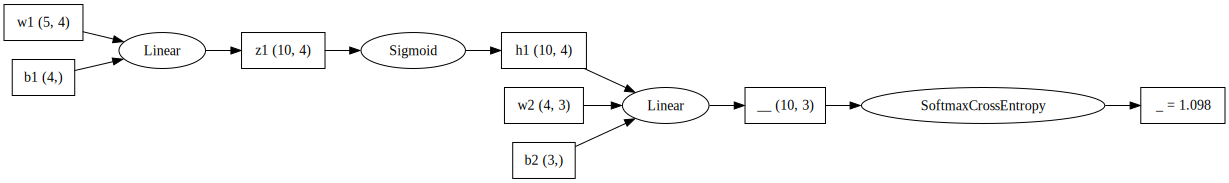

In [35]:
loss.to_graphviz()  # re-run this a few times if variables have names like '__'

Provedeme zpětnou propagaci:

In [36]:
loss.backprop()

Konečně trochu pocítíme výhodu automatického výpočtu gradientů, tzv. autogradu. Všechny uzly v grafu typu `Variable` teď mají vyplněny atribut `grad`, který obsahuje gradient $\partial l/\partial u$, kde $l$ je celkový loss a $u$ je nějaký uzel. Jelikož vstup jsme nechali jako `torch.Tensor`, gradienty jsme obdrželi pouze na parametry sítě `W1, b1, W2, b2`.

In [37]:
w1.grad

tensor([[ 1.65e-04,  5.44e-05,  4.43e-05,  5.23e-05],
        [ 8.87e-06,  4.68e-06, -4.19e-06, -3.99e-08],
        [-1.03e-05, -1.02e-06, -1.17e-05, -7.13e-06],
        [-5.01e-05,  1.59e-05, -1.35e-04, -6.86e-05],
        [-1.70e-06,  2.21e-05, -8.54e-05, -3.74e-05]])

In [38]:
b1.grad

tensor([ 3.56e-06,  4.59e-05, -1.67e-04, -7.16e-05])

In [39]:
w2.grad

tensor([[-0.08, -0.03,  0.12],
        [-0.08, -0.03,  0.12],
        [-0.08, -0.03,  0.12],
        [-0.08, -0.03,  0.12]])

In [40]:
b2.grad

tensor([-0.17, -0.07,  0.23])

Pokud bychom nyní chtěli síť trénovat, updatovali bychom gradienty např. standardním SGD pravidlem jako např. `W1.data -= learning_rate * W1.grad`.

# Objektové rozhraní: `ans.modules` a třída `Module`

Systém ovšem stále ještě není optimálně konfigurovatelný.
1. Musíme manuálně inicializovat parametry. Lepší by bylo, kdybychom např. u funkce `Linear` mohli jednoduše zadat požadované rozměry vstupu a výstupu a vše ostatní by bylo schované v její implementaci.
2. Musíme rovněž specifikovat dopředný průchod. Mohli bychom vše např. navrhnout tak, že zadáme pouze posloupnost požadovaných operací, která se má se vstupem v daném pořadí provést.

Základní stavební bloky si proto navrhneme tak, abychom je mohli používat jako objekty. Např. lineární vrstvu zadefinujeme jako třídu `Linear` a budeme používat takto:
``` python
x = torch.randn(10, 5)  # data (num_inputs, input_size)
linear = ans.modules.Linear(5, 4)  # (input_size, output_size)
z = linear(x)  # z = xW + b
```

Všechny takto navržené vrstvy umístíme do modulu `ans.modules` a budou dědit od základní třídy `Module`, která implementuje funkcionalitu společnou pro všechny vrstvy - např. navrácení seznamu parametrů či přepis magické metody `__call__` apod. - a zamezuje tak zbytečné duplicitě kódu. Každá vrstva odvozená od `Module` musí přepsat:
1. `forward`, kde definuje dopředný průchod,
2. nepovinně `__init__`, kde vyřeší příp. inicializaci parametrů apod.

Nebudeme přitom samozřejmě reimplementovat lineární a sigmoid funkce znovu, ale z vrstev odvozených z `Module` budeme volat funkce z modulu `ans.functional`.

## Vrstva `Linear`

Lineární funkce jako vrstva by měla:
- uchovávat v sobě a v metodě `__init__` automaticky vhodně inicializovat parametry $\boldsymbol{w}$ a $\boldsymbol{b}$, tedy váhy a bias
- v dopředném průchodu `forward` vypočítat výstup jako $\boldsymbol{z}_n = \boldsymbol{x}_n\cdot\boldsymbol{w} + \boldsymbol{b}$

Inicializovat váhy budeme jednou z variant metody Xavier, kde prvky váhové matice $\boldsymbol{w} = [w_{d,c}]$ s rozměry $D \times C$ pocházejí z rovnoměrného náhodného rozdělení
$$
w_{d,c} \sim \mathcal{U}\left(\frac{-1}{\sqrt D}, \frac{+1}{\sqrt D}\right)
$$
Použijeme k tomu metodu [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html).

Bias inicializujeme na nuly metodou [`torch.zeros`](https://pytorch.org/docs/stable/generated/torch.zeros.html).

Váhová matice $\boldsymbol{w}$ a bias vektor $\boldsymbol{b}$ musejí být definovány a inicializovány v mětodě `__init__` třídy `Linear` jako atributy typu `Variable`, aby na ně `grad_fn`, která se automaticky přiřazuje do výstupní `Variable` v metodě `Function.apply` vracela gradient. Základní třída `Module` rovněž definuje metodu `named_parameters()`, která vrací seznam všech trénovatelných parametrů daného modulu, přičemž za takové parametry považuje všechny atributy typu `Variable`.

Dopředný průchod `Linear.forward` by měl volat `ans.functional.Linear.apply`.

### TODO: implementujte vrstvu `Linear`

In [43]:
test_neural_library.TestLinearModule.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok
test_init (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.005s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Vrstva `Sigmoid`

Funkce Sigmoid jako vrstva bude jednodušší. Nemá žádné parametry, a tak nám bude stačit přepsat pouze `forward` tak, aby volal `ans.functional.Sigmoid.apply`. I bez parametrů bude objektově navržený sigmoid výhodný, protože ho půjde jednoduše přidat jako vrstvu do obecné dopředné vícerstvé sítě (multilayer perceptronu).

### TODO: implementujte vrstvu `Sigmoid`

In [45]:
test_neural_library.TestSigmoidModule.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

## Vrstva `SoftmaxCrossEntropy`

Implementace `SoftmaxCorssEntropy` bude jednoduchá podobně jako vrstva `Sigmoid`, protože opět nemá žádné parametry. Dopředný průchod `forward` tedy stačí pouze definovat, aby volal `ans.functional.softax_corss_entropy`.

### TODO: implementujte vrstvu `SoftmaxCrossEntropy`

In [47]:
test_neural_library.TestSoftmaxCrossEntropyModule.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Konfigurovatelný vícevrstvý perceptron pomocí třídy `ans.modules.Sequential`

Konečně máme definovány základní funkční bloky, které nyní můžeme libovolně skládat za sebe a snadno parametrizovat (předávat hyperparametry). Obecný vícevrstvý perceptron implementuje třída `ans.modules.Sequential`. Při vytváření převezme seznam vrstev v pořadí, v jakém by se měly postupně aplikovat na vstup. Funkcionalita kopíruje třídu [Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) knihovny PyTorch. Viz příklad:

In [48]:
model = ans.modules.Sequential(
    ans.modules.Linear(4, 4),
    ans.modules.Sigmoid(),
    ans.modules.Linear(4, 3),
    ans.modules.Sigmoid(),
    ans.modules.Linear(3, 2)
)
model

Každá třída odvozená od `ans.modules.Module` dědí metodu `named_parameters()`, která projde danou instanci a vrátí seznam všech jejích atributů typu `Variable`, přičemž jim zároveň přiřadí jméno a to i rekurzivně pro vnořené objekty. Metodu později využijeme např. pro optimalizaci.

In [49]:
model.named_parameters()

[('0.bias', Variable(shape=(4,), grad_fn=None)),
 ('0.weight', Variable(shape=(4, 4), grad_fn=None)),
 ('2.bias', Variable(shape=(3,), grad_fn=None)),
 ('2.weight', Variable(shape=(4, 3), grad_fn=None)),
 ('4.bias', Variable(shape=(2,), grad_fn=None)),
 ('4.weight', Variable(shape=(3, 2), grad_fn=None))]

In [50]:
x = randn_var(5, 4, dtype=torch.float32)
x

Variable(shape=(5, 4), grad_fn=None)

In [51]:
ans.autograd.gradcheck(model, (x,))  # calls backprop

dinput0 ok: rel_err=9.575e-04, abs_err=2.071e-06


True

In [54]:
model.zero_grad()  # cleanup after backprop

In [53]:
z = model(x)
z

Variable(shape=(5, 2), grad_fn=Function.apply.<locals>.grad_fn)

In [55]:
y = torch.randint(2, (5,))
y

tensor([1, 0, 1, 0, 0])

In [56]:
l = ans.functional.SoftmaxCrossEntropy.apply(z, y)
l

Variable(0.7633880376815796, grad_fn=Function.apply.<locals>.grad_fn)

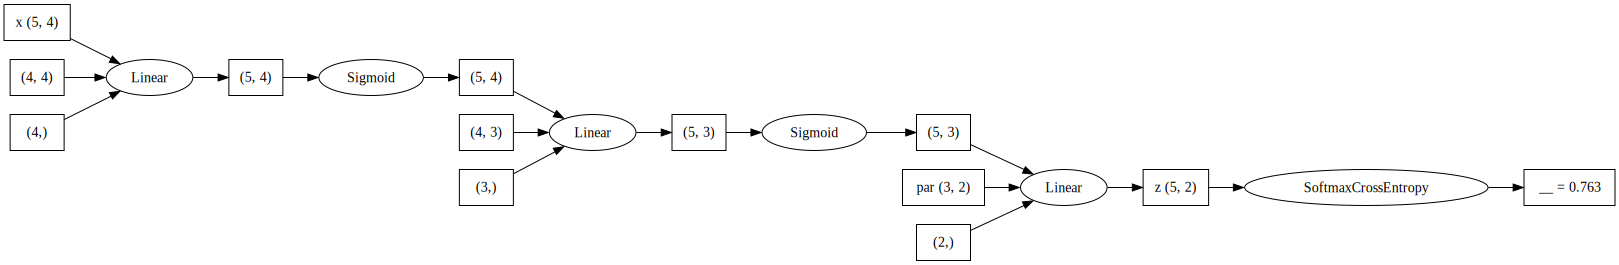

In [71]:
l.to_graphviz()

In [70]:
for name, par in model.named_parameters():
    print(f"{name}: {par.grad}")

0.bias: tensor([ 0.01, -0.00,  0.00, -0.03])
0.weight: tensor([[-0.01,  0.00, -0.00,  0.04],
        [ 0.01, -0.00,  0.00, -0.03],
        [-0.01,  0.00, -0.00,  0.04],
        [ 0.01, -0.00,  0.00, -0.05]])
2.bias: tensor([0.11, 0.12, 0.01])
2.weight: tensor([[0.07, 0.08, 0.00],
        [0.08, 0.08, 0.00],
        [0.07, 0.08, 0.00],
        [0.04, 0.05, 0.00]])
4.bias: tensor([-0.63,  0.63])
4.weight: tensor([[-0.33,  0.33],
        [-0.27,  0.27],
        [-0.30,  0.30]])


In [68]:
l.backprop()

In [67]:
for name, par in model.named_parameters():
    print(f"{name}: {par.grad}")

0.bias: tensor([ 0.00, -0.00,  0.00, -0.00])
0.weight: tensor([[-0.00,  0.00, -0.00,  0.01],
        [ 0.00, -0.00,  0.00, -0.00],
        [-0.00,  0.00, -0.00,  0.01],
        [ 0.00, -0.00,  0.00, -0.01]])
2.bias: tensor([0.02, 0.02, 0.00])
2.weight: tensor([[0.01, 0.02, 0.00],
        [0.02, 0.02, 0.00],
        [0.01, 0.02, 0.00],
        [0.01, 0.01, 0.00]])
4.bias: tensor([-0.21,  0.21])
4.weight: tensor([[-0.11,  0.11],
        [-0.09,  0.09],
        [-0.10,  0.10]])


In [69]:
for name, par in model.named_parameters():
    par.data -= 1e-3 * par.grad  # SGD update with learning rate of 0.001